# Chapter 9. Extensions

Compute and plot the numerical results of Section 9.2. The commented code is in charge of loading simulation results that might be added later.

## Package imports and global variable definitions

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
# uncomment this line if you prefer dynamic matplotlib plots
# %matplotlib notebook

# change the default figure size
# pylab.rcParams['figure.figsize'] = (10.0, 6.0)
pylab.rcParams['legend.fontsize'] = 12

In [3]:
# useful in the function multi_dispatcher_dynamic
from scipy import special

In [4]:
# global variables
ρρ = linspace(4., 0, 50, endpoint=False)
I = 10
μ = 1.

## Function definitions

All numerical results are for two dispatchers only. Incoming jobs have no assignment constraints, so that they are only rejected if their dispatcher is empty of tokens. We also assume that all computers have the same unit capacity $\mu = 1$.

### Single dispatcher

Compute the normalization constant in a cluster with a single dispatcher.

In [5]:
def single_dispatcher_normalization(l, μ, ν):
    # parameters
    I = len(l)
    cuml = zeros(I, dtype=int)
    cuml[1:] = cumsum(l[:-1])
    
    # initialization: π_0
    π = ones(1, dtype=float64)
    
    for i in range(I):
        # recursion:  derive π_{i+1} from π_i
        
        # compute p_{i+1}
        p = ones(l[i] + 1, dtype=float64)
        p[1:] = cumprod(μ[i] / (ν * arange(1, l[i]+1)), dtype=float64)
        
        # make the outer product of π_i with p_{i+1}
        π = outer(π, p[::-1])
        
        # multiply each coefficient by t! / s!
        for s in range(cuml[i] + 1):
            quotient = ones(l[i] + 1, dtype=float64)
            quotient[1:] = cumprod(s + arange(1, l[i] + 1), dtype=float64)
            π[s] *= quotient[::-1]
        
        # sum over the (anti)diagonals
        π = [trace(π, n) for n in range(l[i], -cuml[i] - 1, -1)]
    
    return sum(π)

### Multiple dispatchers with a static routing

We first apply Equation (9.10) of the manuscript with $R = 2$ dispatchers. Since jobs have no compatibility constraints, the balance functions $\Lambda_1$ and $\Lambda_2$ defined in (9.11) have the form (1.8).
We obtain that the normalizing constant is given by
\begin{align*}
G
&= \sum_{y_1 + y_2 \le \ell}
\binom{y_{1,1} + \ldots + y_{1,I}}{y_{1,1}, \ldots, y_{1,I}}
\binom{y_{2,1} + \ldots + y_{2,I}}{y_{2,1}, \ldots, y_{2,I}}
\prod_{i \in \mathcal{I}}
\left( \frac{p_1 \mu}{\nu_1} \right)^{y_{1,i}} \left( \frac{p_2 \mu}{\nu_2} \right)^{y_{2,i}}.
\end{align*}
If we compute $G$ by summing over all values of $y_1 + y_2 \le \ell$, the complexity is $O(\ell_1 \cdots \ell_I)$, which is too high with the values we consider (with $I = 10$ and $\ell_1 = \ldots = \ell_I = 6$, we obtain $\ell_1 \cdots \ell_I = 6^{10} \approx 6.05 \times10^7$).
The method we now describe allows us to obtain the same result with a complexity $O(I^3 \times \max(\ell_1,\ldots,\ell_I)^4)$.

We let $\gamma_1 = \frac{p_1 \mu}{\nu_1}$ and $\gamma_2 = \frac{p_2 \mu}{\nu_2}$,
so that $G$ can be rewritten as
\begin{align*}
G
&= \sum_{y_1 + y_2 \le \ell}
\binom{y_{1,1} + \ldots + y_{1,I}}{y_{1,1}, \ldots, y_{1,I}}
\binom{y_{2,1} + \ldots + y_{2,I}}{y_{2,1}, \ldots, y_{2,I}}
{\gamma_1}^{y_{1,1} + \ldots + y_{1,I}}
{\gamma_2}^{y_{2,1} + \ldots + y_{2,I}}.
\end{align*}

We rewrite this as
$$
G
= \sum_{\substack{m_1, m_2 \in \mathbb{N}: \\ m_1 + m_2 \le \ell_1 + \ldots + \ell_I}}
G^I_{m_1, m_2},
$$
with
$$
G^I_{m_1, m_2}
= \sum_{\substack{y_1 + y_2 \le \ell: \\
y_{1,1} + \ldots + y_{1,I} = m_1, \\
y_{2,1} + \ldots + y_{2,I} = m_2}}
\binom{m_1}{y_{1,1}, \ldots, y_{1,I}}
\binom{m_2}{y_{2,1}, \ldots, y_{2,I}}
{\gamma_1}^{m_1} {\gamma_2}^{m_2}.
$$

We will compute $G^I_{m_1, m_2}$
for each $m_1 = 0, \ldots, \ell_1 + \ldots \ell_i$
and each $m_2 = 0, \ldots, \ell_1 + \ldots + \ell_i - m_1$
by induction over $i = 0, \ldots, I$.
In order to simplify the formulas, we introduce the notations
$y_{1,:i} = (y_{1,1}, \ldots, y_{1,i})$
and $y_{2,:i} = (y_{2,1}, \ldots, y_{2,i})$.
We have
\begin{align*}
G^I_{m_1, m_2}
&= \sum_{\substack{n_1, n_2 \in \mathbb{N}: \\
n_1 \le m_1, n_2 \le m_2, \\
n_1 + n_2 \le \ell_1 + \ldots + \ell_{I-1}, \\
(m_1 - n_1) + (m_2 - n_2) \le \ell_I}}
\sum_{\substack{y_{1,:I-1} + y_{2,:I-1} \le \ell_{:I-1} \\
		y_{1,1} + \ldots + y_{1,I-1} = n_1 \\
		y_{2,1} + \ldots + y_{2,I-1} = n_2}}
\frac{m_1!}{y_{1,1}! \cdots y_{1,I-1}! (m_1-n_1)!}
\frac{m_2!}{y_{2,1}! \cdots y_{2,I-1}! (m_2-n_2)!}
{\gamma_1}^s {\gamma_2}^{m_2}, \\
&= \sum_{\substack{n_1, n_2 \in \mathbb{N}: \\
n_1 \le m_1, n_2 \le m_2, \\
n_1 + n_2 \le \ell_1 + \ldots + \ell_{I-1}, \\
(m_1 - n_1) + (m_2 - n_2) \le \ell_I}}
\begin{aligned}[t]
	&\frac{m_1!}{n_1!} \frac{m_2!}{n_2!}
	\frac{{\gamma_1}^{m_1-n_1}}{(m_1-n_1)!}
	\frac{{\gamma_2}^{m_2-n_2}}{(m_2-n_2)!} \\
	&\times \sum_{\substack{
			y_{1,:I-1} + y_{2,:I-1} \le \ell_{:I-1}: \\
			y_{1,1} + \ldots + y_{1,I-1} = n_1, \\
			y_{2,1} + \ldots + y_{2,I-1} = n_2
		}}
	\frac{n_1!}{y_{1,1}! \cdots y_{1,I-1}!}
	\frac{n_2!}{y_{2,1}! \cdots y_{2,I-1}!}
	{\gamma_1}^{n_1} {\gamma_2}^{n_2}.
\end{aligned}
\end{align*}
We recognize the expression of $G^{I-1}_{n_1,n_2}$
in the most inner sum, so that we obtain
\begin{align*}
G^I_{m_1, m_2}
&= \sum_{\substack{n_1, n_2 \in \mathbb{N}: \\
n_1 \le m_1, n_2 \le m_2, \\
n_1 + n_2 \le \ell_1 + \ldots + \ell_{I-1}, \\
(m_1 - n_1) + (m_2 - n_2) \le \ell_I}}
\frac{m_1!}{n_1!} \frac{m_2!}{n_2!}
\frac{{\gamma_1}^{m_1-n_1}}{(m_1-n_1)!} \frac{{\gamma_2}^{m_2-n_2}}{(m_2-n_2)!}
G^{I-1}_{n_1,n_2}.
\end{align*}

In [6]:
def multi_dispatcher_static_normalization(I, l, γ1, γ2):
    maxl = max(l)
    cuml = cumsum(l)
    
    # precompute some results
    cumγ1 = ones(maxl + 1, dtype=float64)
    cumγ1[1:] = cumprod(γ1 / arange(1, maxl + 1))
    
    cumγ2 = ones(maxl + 1, dtype=float64)
    cumγ2[1:] = cumprod(γ2 / arange(1, maxl + 1))
    
    # i = 0
    oldπ = (outer(γ1**arange(l[0] + 1), γ2**arange(l[0] + 1))
            * (tri(l[0] + 1)[::-1]))
    
    # i = 1,...,I-1
    for i in range(1, I):
        π = zeros((cuml[i] + 1, cuml[i] + 1), dtype=float64)
        
        for n1 in range(cuml[i-1] + 1):
            for n2 in range(cuml[i-1] - n1 + 1):
                prod1 = float64(1.)
                for m1 in range(n1, n1 + l[i] + 1):
                    prod2 = float64(1.)
                    for m2 in range(n2, n1 + n2 + l[i] - m1 + 1):
                        π[m1, m2] += oldπ[n1, n2] * cumγ1[m1-n1] * cumγ2[m2-n2] * prod1 * prod2
                        prod2 *= (m2 + 1)
                    prod1 *= (m1 + 1)
        
        oldπ = copy(π)
    
    return sum(sum(π))

In [7]:
def multi_dispatcher_static_loss(I, l, μ, ρρ, α1, p1):
    ll = l * ones(I, dtype=int)
    return [(
        (1 - α1) * single_dispatcher_normalization(ll, p1 * μ * ones(I), α1 * I * μ * ρ)
        + α1 * single_dispatcher_normalization(ll, (1 - p1) * μ * ones(I), (1 - α1) * I * μ * ρ)
    ) / multi_dispatcher_static_normalization(I, ll, (p1 * μ) / (α1 * I * ρ),
                                              ((1 - p1) * μ) / ((1 - α1) * I * ρ))
    for ρ in ρρ]

### Multple dispatchers with a dynamic routing

We let $q = (q_1,\ldots,q_I)$.
We have $\mu_i = \mu$ for each $i \in \mathcal{I}$.
\begin{align*}
	G
	&= \sum_{y_1 \le q} \sum_{y_2 \le q}
	\begin{aligned}[t]
		&\binom{y_{1,1} + \ldots + y_{1,I}}{y_{1,1}, \ldots, y_{1,I}}
		\left( \frac1{\nu_1} \right)^{y_{1,1} + \ldots + y_{1,I}}
		\binom{y_{2,1} + \ldots + y_{2,I}}{y_{2,1}, \ldots, y_{2,I}}
		\left( \frac1{\nu_2} \right)^{y_{2,1} + \ldots + y_{2,I}} \\
		&\times \prod_{i \in \mathcal{I}}
		\binom{\ell_i - y_{1,i} - y_{2,i}}{q_i - y_{1,i}, q_i - y_{2,i}}
		\mu^{y_{1,i} + y_{2,i}}.
	\end{aligned}
\end{align*}
We let $\gamma_1 = \frac\mu{\nu_1}$
and $\gamma_2 = \frac\mu{\nu_2}$,
so that $G$ can be rewritten as
\begin{align*}
	G
	&= \sum_{y_1 \le q} \sum_{y_2 \le q}
	\begin{aligned}[t]
		&\binom{y_{1,1} + \ldots + y_{1,I}}{y_{1,1}, \ldots, y_{1,I}}
		{\gamma_1}^{y_{1,1} + \ldots + y_{1,I}}
		\binom{y_{2,1} + \ldots + y_{2,I}}{y_{2,1}, \ldots, y_{2,I}}
		{\gamma_2}^{y_{2,1} + \ldots + y_{2,I}} \\
		&\times \prod_{i \in \mathcal{I}}
		\binom{\ell_i - y_{1,i} - y_{2,i}}{q_i - y_{1,i}, q_i - y_{2,i}}.
	\end{aligned}
\end{align*}
We can rewrite this as
\begin{align*}
	G = \sum_{\substack{m_1, m_2 \in \mathbb{N}: \\
			m_1 \le q_1 + \ldots + q_I, \\
			m_2 \le q_1 + \ldots + q_I}}
		G^I_{m_1, m_2},
\end{align*}
with
\begin{align*}
	G^I_{m_1,m_2}
	&= \sum_{\substack{y_1 \le q: \\
			y_{1,1} + \ldots + y_{1,I} = m_1}}
	\sum_{\substack{y_2 \le q: \\
			y_{2,1} + \ldots + y_{2,I} = m_2}}
	\begin{aligned}[t]
		&\binom{m_1}{y_{1,1}, \ldots, y_{1,I}}
		{\gamma_1}^{y_{1,1}, \ldots, y_{1,I}}
		\binom{m_2}{y_{2,1}, \ldots, y_{2,I}}
		{\gamma_2}^{y_{2,1}, \ldots, y_{2,I}} \\
		&\times \prod_{i \in \mathcal{I}}
		\binom{\ell_i - y_{1,i} - y_{2,i}}{q_i - y_{1,i}, q_i - y_{2,i}},
	\end{aligned} \\
	&= \sum_{\substack{n_1, n_2 \in \mathbb{N}: \\
			n_1 \le m_1, n_2 \le m_2, \\
			n_1 \le q_1 + \ldots + q_{I-1}, \\
			n_2 \le q_1 + \ldots + q_{I-1}, \\
			m_1 - n_1 \le q_I, \\
			m_2 - n_2 \le q_I}}
    \sum_{\substack{y_{1,:I-1} \le q_{:I-1}, \\ y_{1,1} + \ldots + y_{1,I-1} = n_1}}
	\sum_{\substack{y_{2,:I-1} \le q_{:I-1}, \\ y_{2,1} + \ldots + y_{2,I-1} = n_2}}
	\begin{aligned}[t]
		&\frac{m_1!}{y_{1,1}! \cdots y_{1,I-1}! (m_1 - n_1)!}
		\frac{m_2!}{y_{2,1}! \cdots y_{2,I-1}! (m_2 - n_2)!}
		{\gamma_1}^{m_1} {\gamma_2}^{m_2} \\
		&\times \prod_{i=1}^{I-1}
		\binom{\ell_i - y_{1,i} - y_{2,i}}{q_i - y_{1,i}, q_i - y_{2,i}}
		\times
		\binom{\ell_I - (m_1-n_2) - (m_2-n_2)}
		{q_i - (m_1-n_2), q_i - (m_2-n_2)},
	\end{aligned} \\
	&= \sum_{\substack{n_1, n_2 \in \mathbb{N}: \\
			n_1 \le m_1, n_2 \le m_2, \\
			n_1 \le q_1 + \ldots + q_{I-1}, \\
			n_2 \le q_1 + \ldots + q_{I-1}, \\
			m_1 - n_1 \le q_I, \\
			m_2 - n_2 \le q_I}}
	\frac{m_1!}{n_1!} \frac{m_2!}{n_2!}
	\frac{{\gamma_1}^{m_1-n_1}}{(m_1-n_1)!}
	\frac{{\gamma_2}^{m_2-n_2}}{(m_2-n_2)!}
	\binom{\ell_I - (m_1-n_1) - (m_2-n_2)}
	{q_i - (m_1-n_1), q_i - (m_2-n_2)}
	G^{I-1}_{n_1,n_2}.
\end{align*}

In [8]:
def multi_dispatcher_dynamic_normalization(I, l, γ1, γ2):
    q = l // 2
    
    # precompute some results
    cumγ1 = ones(q + 1, dtype=float64)
    cumγ1[1:] = cumprod(γ1 / arange(1, q + 1))
    
    cumγ2 = ones(q + 1, dtype=float64)
    cumγ2[1:] = cumprod(γ2 / arange(1, q + 1))
    
    binomial = ones((q + 1, q + 1))
    for m1 in range(q + 1):
        for m2 in range(q + 1):
            binomial[m1, m2] = special.binom(l - m1 - m2, q - m1)
    
    # i = 0
    oldπ = outer(γ1**arange(l + 1), γ2**arange(l + 1)) * (tri(l + 1)[::-1])
    oldπ = oldπ[:q + 1,:q + 1] * binomial
    
    # i = 1,...,I-1
    for i in range(1, I):
        π = zeros((q * (i + 1) + 1, q * (i + 1) + 1), dtype=float64)
        
        for n1 in range(q * i + 1):
            for n2 in range(min(q * i, l * i - n1) + 1):
                prod1 = float64(1.)
                for m1 in range(n1, n1 + q + 1):
                    prod2 = float64(1.)
                    for m2 in range(n2, n2 + q + 1):
                        π[m1, m2] += (oldπ[n1, n2] * cumγ1[m1 - n1] * cumγ2[m2 - n2]
                                      * prod1 * prod2 * binomial[m1 - n1, m2 - n2])
                        prod2 *= (m2 + 1)
                    prod1 *= (m1 + 1)
        
        oldπ = copy(π)
    
    return sum(sum(π))

In [9]:
def multi_dispatcher_dynamic_loss(I, l, α1, μ, ρρ):
    return [ (
        (1 - α1) * multi_dispatcher_dynamic_normalization(I, l, μ / (α1 * I * ρ), 0.)
        + α1 * multi_dispatcher_dynamic_normalization(I, l, 0., μ / ((1 - α1) * I * ρ))
    ) / multi_dispatcher_dynamic_normalization(I, l, μ / (α1 * I * ρ), μ / ((1 - α1) * I * ρ))
    for ρ in ρρ ]

## Numerical results

### Balanced arrivals

In [10]:
# parameters
ll = [2, 4, 6]
α1 = .5 # proportion of arrivals at dispatcher 1

In [11]:
static = [multi_dispatcher_static_loss(I, l, μ, ρρ, α1, p1=α1) for l in ll]
dynamic = [multi_dispatcher_dynamic_loss(I, l, α1, μ, ρρ) for l in ll]

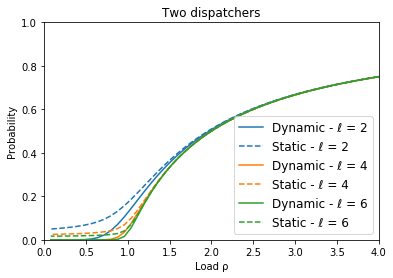

In [12]:
# plot
for i,l in enumerate(ll):
    plot(ρρ, dynamic[i], color = 'C'+str(i), label = "Dynamic - ℓ = %d" % l)
    plot(ρρ, static[i], '--', label = "Static - ℓ = %d" % l)

#for i,l in enumerate(ll):
#    ρρρ, exp_blocking \
#    = loadtxt('data/dispatchers' + str(l) + '-balanced-blocking', delimiter='\t', unpack=True)
#    plot(ρρρ, exp_blocking, color = 'C' + str(i), linestyle="None", marker="x", label="Static - ℓ = " + str(l))

#for i,l in enumerate(ll):
#    ρρρ, exp_blocking \
#    = loadtxt('data/baf' + str(l) + '-balanced-blocking', delimiter='\t', unpack=True)
#    plot(ρρρ, exp_blocking, color = 'C' + str(i), linestyle="None", marker="+", label="Dynamic - ℓ = " + str(l))

xlim(0,4); ylim(0,1)
legend(loc=4); title("Two dispatchers")
xlabel("Load ρ"); ylabel("Probability")
show()

### Imbalanced arrivals

In [13]:
# parameters
ll = [2, 4, 6]
α1 = .8 # proportion of arrivals at dispatcher 1

In [14]:
uniform_static = [multi_dispatcher_static_loss(I, l, μ, ρρ, α1, p1=.5) for l in ll]
best_static = [multi_dispatcher_static_loss(I, l, μ, ρρ, α1, p1=α1) for l in ll]
dynamic = [multi_dispatcher_dynamic_loss(I, l, α1, μ, ρρ) for l in ll]

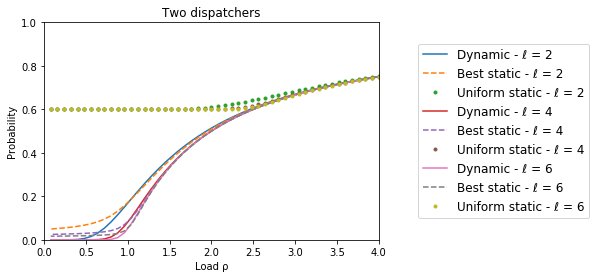

In [15]:
# plot
for i,l in enumerate(ll):
    plot(ρρ, dynamic[i], label = "Dynamic - ℓ = %d" % l)
    plot(ρρ, best_static[i], '--', label = "Best static - ℓ = %d" % l)
    plot(ρρ, uniform_static[i], '.', label = "Uniform static - ℓ = %d" % l)

#for i,l in enumerate(ll):
#    ρρρ, exp_blocking \
#    = loadtxt('data/dispatchers' + str(l) + '-imbalanced-blocking', delimiter='\t', unpack=True)
#    plot(ρρρ, exp_blocking, color = 'C' + str(i), linestyle="None", marker="x", label="Static - ℓ = " + str(l))

#for i,l in enumerate(ll):
#    ρρρ, exp_blocking \
#    = loadtxt('data/baf' + str(l) + '-imbalanced-blocking', delimiter='\t', unpack=True)
#    plot(ρρρ, exp_blocking, color = 'C' + str(i), linestyle="None", marker="+", label="Dynamic - ℓ = " + str(l))

xlim(0,4); ylim(0,1)
legend(loc=6, bbox_to_anchor=(1.1, .5)); title("Two dispatchers")
xlabel("Load ρ"); ylabel("Probability")
show()

### Homogeneous

In [16]:
# parameters
l = 6
α1 = .5 # proportion of arrivals at dispatcher 1

In [17]:
static = multi_dispatcher_static_loss(I, l, μ, ρρ, α1, p1=α1)
dynamic = multi_dispatcher_dynamic_loss(I, l, α1, μ, ρρ)

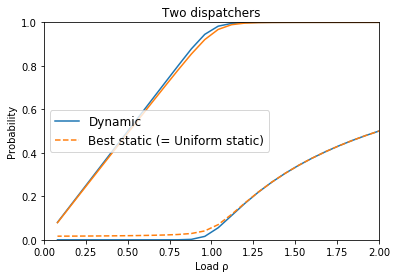

In [18]:
# plot
plot(ρρ, dynamic, color = 'C0', label = "Dynamic")
plot(ρρ, ρρ * [1. - β for β in dynamic], color = 'C0')
plot(ρρ, static, '--', color = 'C1', label = "Best static (= Uniform static)")
plot(ρρ, ρρ * [1. - β for β in static], color = 'C1')

#ρρρ, exp_blocking \
#= loadtxt('data/dispatchers' + str(l) + '-homo-dynamic-blocking', delimiter='\t', unpack=True)
#plot(ρρρ, exp_blocking, color = 'C0', linestyle="None", marker="+", label="Dynamic")

#ρρρ, exp_blocking \
#= loadtxt('data/dispatchers' + str(l) + '-homo-static-blocking', delimiter='\t', unpack=True)
#plot(ρρρ, exp_blocking, color = 'C1', linestyle="None", marker="x", label="Best static")

xlim(0,2); ylim(0,1)
legend(loc='best'); title("Two dispatchers")
xlabel("Load ρ"); ylabel("Probability")
show()

### Heterogeneous

In [19]:
# parameters
l = 6
α1 = .8 # proportion of arrivals at dispatcher 1

In [20]:
uniform_static = multi_dispatcher_static_loss(I, l, μ, ρρ, α1, p1=.5)
best_static = multi_dispatcher_static_loss(I, l, μ, ρρ, α1, p1=α1)
dynamic = multi_dispatcher_dynamic_loss(I, l, α1, μ, ρρ)

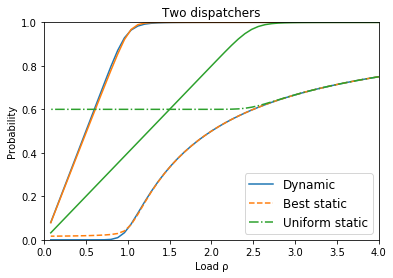

In [21]:
# plot
plot(ρρ, dynamic, color = 'C0', label = "Dynamic")
plot(ρρ, ρρ * [1. - β for β in dynamic], color = 'C0')
plot(ρρ, best_static, '--', color = 'C1', label = "Best static")
plot(ρρ, ρρ * [1. - β for β in best_static], color = 'C1')
plot(ρρ, uniform_static, '-.', color = 'C2', label = 'Uniform static')
plot(ρρ, ρρ * [1. - β for β in uniform_static], color = 'C2')

#ρρρ, exp_blocking \
#= loadtxt('data/dispatchers' + str(l) + '-hete-dynamic-blocking', delimiter='\t', unpack=True)
#plot(ρρρ, exp_blocking, color = 'C0', linestyle="None", marker="x", label="Dynamic")

#ρρρ, exp_blocking \
#= loadtxt('data/dispatchers' + str(l) + '-hete-best_static-blocking', delimiter='\t', unpack=True)
#plot(ρρρ, exp_blocking, color = 'C1', linestyle="None", marker="+", label="Best static")

#ρρρ, exp_blocking \
#= loadtxt('data/dispatchers' + str(l) + '-hete-uniform_static-blocking', delimiter='\t', unpack=True)
#plot(ρρρ, exp_blocking, color = 'C2', linestyle="None", marker="x", label="uniform_static static")

xlim(0,4); ylim(0,1)
legend(loc=4); title("Two dispatchers")
xlabel("Load ρ"); ylabel("Probability")
show()

In [22]:
# save
df = pd.DataFrame({'rho': ρρ,
                    'db': dynamic,
                    'do': ρρ * [1. - β for β in dynamic],
                    'ob': best_static,
                    'oo': ρρ * [1. - β for β in best_static],
                    'ub': uniform_static,
                    'uo': ρρ * [1. - β for β in uniform_static]
                    })

fn = "data/theo-jiq-comp.csv"
df.to_csv(fn, index = False)